# sequence prediction sandbox


In [1]:
import torch
from torch.utils.data import TensorDataset,DataLoader
from torch import nn

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(7) #10

import utils as u

## Load data 

In [2]:
def load_data(
        upstream_region_file,
        data_mat_file, 
        sample2cond_file, 
        sample_file, 
        condition_file,
        coded_meta_file
        ):
    '''
    Wrapper function to load data from files into relavent objects
    '''
    # load upstream seq regions
    seqs = u.load_promoter_seqs(upstream_region_file)
    loc2seq = dict([(x,z) for (x,y,z) in seqs])
    
    # load TPM data
    tpm_df = pd.read_csv(data_mat_file,sep='\t').fillna('')

    
    # load mapping from sample to condition
    with open(sample2cond_file,'r') as f:
        sample2condition = dict(x.strip().split() for x in f.readlines())

    
    # load sample to include file
    if sample_file:
        with open(sample_file,'r') as f:
            samples = list(x.strip() for x in f.readlines())
    # if none provided, just use all the samples from the sample2condition dict
    else: 
        samples = list(sample2condition.keys())

        
    # load the conditions to include file
    if condition_file:
        with open(condition_file,'r') as f:
            conditions = list(x.strip() for x in f.readlines())
    # if none provided, just use all the conditions
    else:
        conditions = list(set([sample2condition[x] for x in sample2condition]))

    # load coded metadata file
    meta_df = pd.read_csv(coded_meta_file,sep='\t')
    meta_df['sample'] = meta_df['#sample']+'_tpm'

    return loc2seq, tpm_df, sample2condition, samples, conditions, meta_df

In [3]:
upstream_region_file = 'all_seq_info/all_loci_upstream_regions_w100_min20.fa'
data_mat_file = 'data/extract_TPM_counts.tsv'
sample2cond_file = 'data/sample2condition.txt'
sample_file = None
condition_file = 'data/conditions_to_include.txt'
coded_meta_file = 'data/5G_exp_metadata_coded.tsv'
COND_COLS = ['carbon_source','oxygen_level','nitrate_level','copper_level','lanthanum_level','growth_rate','growth_mode']


loc2seq, tpm_df, sample2condition, samples, conditions, meta_df = load_data(
    upstream_region_file,
    data_mat_file, 
    sample2cond_file, 
    sample_file, 
    condition_file,
    coded_meta_file
)

In [4]:
def format_XY_dfs(tpm_df, meta_df):
    # melt tpm df so every sample is in a row
    tpm_melt = tpm_df[['locus_tag']+samples].melt(id_vars=['locus_tag'],var_name='sample',value_name='tpm')
    tpm_melt['condition'] = tpm_melt['sample'].apply(lambda x: sample2condition[x])

    # also add in upstream seq
    tpm_melt['upstream_region'] = tpm_melt['locus_tag'].apply(lambda x: loc2seq[x])
    
    # get coded metadata conditions from meta_df
    samp2cond_df = meta_df[['sample']+COND_COLS]

    # merge back onto the tpm df
    df = tpm_melt.merge(samp2cond_df,on='sample',how='left')
    
    # reformat full df
    full_df = df[['locus_tag','upstream_region', 'sample','condition']+COND_COLS+['tpm']]
    
    # separate out just X (features) and Y (labels)
    X = full_df[['locus_tag','upstream_region']+COND_COLS]
    Y = full_df['tpm']
    
    return full_df,X,Y
    

In [5]:
full_df, X, Y = format_XY_dfs(tpm_df,meta_df)

In [6]:
full_df

,locus_tag,upstream_region,sample,condition,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode,tpm
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,2.933003
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.607784
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.415515
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,3.200081
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.522728
...,...,...,...,...,...,...,...,...,...,...,...,...
412869,EQU24_RS22135,CCCGGCCGGTTTGGTCTTGTACTGGGTGGTCAACAATACGCTGTCG...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,24.508375
412870,EQU24_RS22140,GCCGCCCAGGGCACCTATCTTACAGTCCGAAGAGTATTAAAGTGTC...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,130.851229
412871,EQU24_RS22145,AATATTGATGTTGTTGTTATGGCCCGAAAAGATGCACTCAATGCAT...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,66.415222
412872,EQU24_RS22150,AAGAACTCACGGCTTTCGTGCCAGAATGGCGACCAAAGGCGGCCGT...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,164.123473


In [7]:
X

,locus_tag,upstream_region,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,2,0,0,3,0,0,0
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,2,0,0,3,0,0,0
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,2,0,0,3,0,0,0
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,2,0,0,3,0,0,0
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,2,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...
412869,EQU24_RS22135,CCCGGCCGGTTTGGTCTTGTACTGGGTGGTCAACAATACGCTGTCG...,2,1,0,3,0,2,1
412870,EQU24_RS22140,GCCGCCCAGGGCACCTATCTTACAGTCCGAAGAGTATTAAAGTGTC...,2,1,0,3,0,2,1
412871,EQU24_RS22145,AATATTGATGTTGTTGTTATGGCCCGAAAAGATGCACTCAATGCAT...,2,1,0,3,0,2,1
412872,EQU24_RS22150,AAGAACTCACGGCTTTCGTGCCAGAATGGCGACCAAAGGCGGCCGT...,2,1,0,3,0,2,1


In [8]:
Y

0           2.933003
1           1.607784
2           1.415515
3           3.200081
4           1.522728
             ...    
412869     24.508375
412870    130.851229
412871     66.415222
412872    164.123473
412873    301.751157
Name: tpm, Length: 412874, dtype: float64

In [9]:
def one_hot_encode(seq):
    #print("one hot encoding...")
    
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'T':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Creat empty matrix.
    #vec=torch.tensor([nuc_d[x] for x in seq])
    vec=np.array([nuc_d[x] for x in seq]).flatten()
        
    return vec

In [10]:
#tl_lin, vl_lin = fit(50, model_lin, loss_func, optimizer, train_dl, test_dl)

In [11]:
def quick_load_and_split_input(data, split_frac=0.8, verbose=False):
    '''
    Given a list of tuples, build a df, ohe the sequences, and randomly split between
    train and test. Not a formal train/test split, just a quick n dirty version.
    
    Return pytorch tensors of x/y train/test
    '''
    # convert data to df and one-hot encode
    df = pd.DataFrame(data, columns = ['seq','score'])
    df['oh'] = df['seq'].apply(lambda x: one_hot_encode(x))

    # train test split
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split df and convert to tensors
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]

    x_train = torch.tensor(list(train_df['oh'].values))
    y_train = torch.tensor(list(train_df['score'].values)).unsqueeze(1)
    x_test  = torch.tensor(list(test_df['oh'].values))
    y_test  = torch.tensor(list(test_df['score'].values)).unsqueeze(1)
    
    if verbose:
        print("Example train seq")
        plt.imshow(x_train[0].reshape((6, 4)), cmap="gray")
        plt.show()
        
        print(idxs)
        print("Train #:", len(train_idxs))
        print("Test #:", len(test_idxs))
        
        print("Y test:", y_test)
        
    return x_train, y_train, x_test, y_test

def build_dataloaders(data, batch_size=4):
    '''
    Given sets of x and y train and test, put into pytorch loaders
    '''
    x_train, y_train, x_test, y_test = quick_load_and_split_input(data, verbose=True)
    
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    test_ds = TensorDataset(x_test, y_test)
    test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
    
    return train_dl, test_dl

In [12]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb.float()), yb.float())

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    train_losses = []    
    val_losses = []
    for epoch in range(epochs):
        #print("TRAIN")
        model.train()
        ts = []
        ns = []
        for xb, yb in train_dl:
            t, n = loss_batch(model, loss_func, xb, yb, opt)
            ts.append(t)
            ns.append(n)
        train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        train_losses.append(train_loss)
        
        #print("EVAL")
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                # loop through test batches
                # returns loss calc for test set batch size
                # unzips into two lists
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
            )
        # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
        #print("losses", losses)
        #print("nums", nums)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [13]:
class DNA_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(24, 1)

    def forward(self, xb):
        # lin wraps up the weights/bias dot product from before
        return self.lin(xb)
    
class DNA_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(128, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) # ?? Linear?

    def forward(self, xb):
        xb = xb.view(-1,6,4).permute(0,2,1) # reshape to 4bs x 4channel x 6len
        #print(xb)
        xb = self.conv_net(xb)
        return xb

In [14]:
def run_model(train_dl,test_dl, model, lr=0.01, epochs=50):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    
    loss_func = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    train_losses, val_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    return model, train_losses, val_losses

def run_linear_model(train_dl,test_dl, lr=0.01, epochs=50):
    model = DNA_Linear()
    
    return run_model(train_dl,test_dl, model)


def run_cnn_model(train_dl,test_dl, lr=0.01, epochs=50):
    model = DNA_CNN()
    return run_model(train_dl,test_dl, model)

In [15]:
def quick_loss_plot(data_label):
    for data, label in data_label:
        plt.plot(data, label=label)
    plt.legend()
    plt.ylabel("MSE loss")
    plt.xlabel("Epoch")
    plt.show()
    
def quick_seq_pred(model, seqs):
    for dna in seqs:
        s = torch.tensor(one_hot_encode(dna))
        pred = model(s.float())
        print(dna, pred.item())

## Fake data

Example train seq


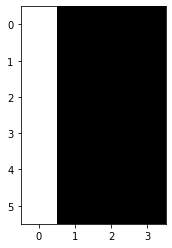

[22, 35, 14, 15, 10, 44, 11, 16, 43, 26, 38, 40, 31, 8, 0, 21, 19, 12, 24, 37, 45, 28, 36, 18, 1, 30, 17, 29, 7, 33, 39, 27, 5, 2, 13, 32, 42, 23, 6, 34, 4, 3, 41, 25, 9, 20]
Train #: 36
Test #: 10
Y test: tensor([[8.0000],
        [7.0000],
        [6.7000],
        [4.0000],
        [9.9000],
        [7.8000],
        [6.6000],
        [1.1000],
        [1.1000],
        [1.1000]], dtype=torch.float64)


In [16]:
# mostly A = 10.0
# mostly C = 7.0
# mostly G = 4.0
# mostly T = 1.0
data = [
    ('AAAAAA', 10.0),
    ('ATAAAA', 9.0),
    ('AAAACA', 9.8),
    ('CCAACA', 8.0),
    ('CCCCCC', 7.0),
    ('CGGACC', 6.8),
    ('CCCGCC', 6.7),
    ('GGGACG', 6.2),
    ('CGGGCG', 5.0),
    ('GGGGGG', 4.0),
    ('GCCGGT', 4.1),
    ('TGGTGT', 3.0),
    ('CGGTTG', 3.4),
    ('TTGTGT', 2.0),
    ('TTTTTT', 1.0),
    ('TAATTA', 5.1),
    ('GAGTGA', 5.3),
    ('AAATAA', 9.1),
    ('AAAAAG', 9.4),
    ('TTAGCT', 3.2),
    ('CAAAAA', 9.9),
    ('ACAAAA', 9.8),
    ('AAAACA', 9.8),
    ('CCAATA', 7.8),
    ('CCCGCC', 6.8),
    ('CGGATC', 6.6),
    ('CACGCC', 6.9),
    ('AGGACG', 6.5),
    ('CGTGCG', 4.9),
    ('GGGGGA', 4.3),
    ('GCCGGA', 4.5),
    ('TGGTGA', 3.5),
    ('CGGTTA', 3.8),
    ('TTGTGA', 2.5),
    ('TTTTTG', 1.1),
    ('TAATAA', 5.6),
    ('GAGTGC', 5.0),
    ('AAATAC', 8.7),
    ('AACAAA', 9.9),
    ('TTCTTT', 1.3),
    ('TTTCTT', 1.2),
    ('TTTTGT', 1.1),
    ('GTTTTT', 1.1),
    ('AACAAA', 9.8),
    ('AAAAGA', 9.7),
    ('TAAAAA', 9.4),
]
train_dl, test_dl = build_dataloaders(data)

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


0 19.20298115313053
1 10.386842203140258
2 6.466837096214294
3 4.596130895614624
4 3.5755373001098634
5 2.925488543510437
6 2.49044725894928
7 2.1887886047363283
8 1.9454148292541504
9 1.7497816801071167
10 1.6098498821258544
11 1.4963623046875
12 1.3915011405944824
13 1.305808925628662
14 1.225673496723175
15 1.1587521851062774
16 1.0937750220298768
17 1.0465195775032043
18 1.00126513838768
19 0.9633267164230347
20 0.9313404589891434
21 0.9025005042552948
22 0.8712363600730896
23 0.8452667653560638
24 0.8125807583332062
25 0.7925148665904999
26 0.7698869854211807
27 0.7457895755767823
28 0.7243365734815598
29 0.7064141631126404
30 0.6986008644104004
31 0.6906477957963943
32 0.6740806877613068
33 0.656878513097763
34 0.6388355821371079
35 0.6230300337076187
36 0.61553173661232
37 0.6059700965881347
38 0.5904154717922211
39 0.5851420998573303
40 0.5752354472875595
41 0.5612780153751373
42 0.5534529894590378
43 0.5447666883468628
44 0.5375030517578125
45 0.5310918867588044
46 0.522345530

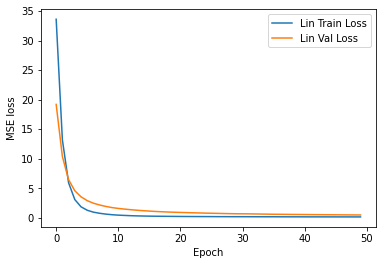

In [17]:
model_lin, tl_lin, vl_lin = run_linear_model(train_dl, test_dl)

# to plot loss
lin_data_label = list(zip([tl_lin,vl_lin], ['Lin Train Loss','Lin Val Loss']))
quick_loss_plot(lin_data_label)

In [18]:
seqs1 = ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT','AACCAA','CCGGGG','GGGTAA', 'TTTCGT',"TGTAAT"]
seqs2 = ['TATAAA', 'TAATAT','CCTATA','AAGCGA','GCGAAA','TTGCGA','GCGTAA', 'TATTAA','TTTATT']

quick_seq_pred(model_lin, seqs1)
print()
quick_seq_pred(model_lin, seqs2)

AAAAAA 10.41738510131836
CCCCCC 5.62603759765625
GGGGGG 3.9000308513641357
TTTTTT 0.9597322940826416
AACCAA 8.132274627685547
CCGGGG 4.4542436599731445
GGGTAA 5.266139507293701
TTTCGT 1.5184788703918457
TGTAAT 5.0711164474487305

TATAAA 7.27061653137207
TAATAT 5.601452827453613
CCTATA 5.6529130935668945
AAGCGA 6.499587535858154
GCGAAA 7.087843894958496
TTGCGA 2.830794334411621
GCGTAA 5.36977481842041
TATTAA 5.552547454833984
TTTATT 2.6778013706207275


# Next with specific patterns that mean higher score

Example train seq


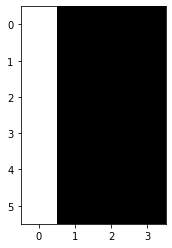

[8, 28, 43, 11, 21, 44, 37, 1, 0, 47, 26, 32, 38, 12, 17, 40, 42, 30, 33, 14, 10, 41, 16, 9, 18, 2, 7, 24, 22, 5, 25, 15, 19, 48, 46, 29, 20, 27, 34, 31, 13, 39, 3, 36, 4, 45, 35, 6, 23]
Train #: 39
Test #: 10
Y test: tensor([[14.8000],
        [ 9.0000],
        [ 0.4000],
        [ 4.1000],
        [ 9.9000],
        [ 0.3000],
        [13.9000],
        [ 0.2000],
        [ 5.0000],
        [ 1.1000]], dtype=torch.float64)


In [19]:
# fake data: 
# TAT = really high
# GCG = really low
data2 = [
    ('AAAAAA', 10.0),
    ('AATATA', 15.0),
    ('TATAAA', 14.9),
    ('TAATAT', 14.8),
    ('ATAAAA', 9.0),
    ('AAAACA', 9.8),
    ('GCGACA', 0.4),
    ('CCCCCC', 7.0),
    ('CGGACC', 6.8),
    ('CTATCC', 13.6),
    ('GGGACG', 6.2),
    ('CGGGCG', 0.5),
    ('GGGGGG', 4.0),
    ('GCCGGT', 4.1),
    ('TGTATT', 12.3),
    ('CGGTTG', 3.4),
    ('TTGCGT', 0.1),
    ('TTTTTT', 1.0),
    ('TAATTA', 5.1),
    ('GAGTGA', 5.3),
    ('AAATAT', 14.9),
    ('AAGCGA', 0.5),
    ('TTAGCT', 3.2),
    ('CAAAAA', 9.9),
    ('ACAAAA', 9.8),
    ('AAAACA', 9.8),
    ('CCTATA', 14.5),
    ('CCCGCC', 6.8),
    ('CGGATC', 6.6),
    ('CACGCG', 0.3),
    ('AGGACG', 6.5),
    ('CGTGCG', 0.3),
    ('GGGGGA', 4.3),
    ('GCCGGA', 4.5),
    ('TGGTGA', 3.5),
    ('CGGTAT', 13.9),
    ('TTGCGA', 0.2),
    ('TTTTTG', 1.1),
    ('TATTAA', 14.7),
    ('GAGTGC', 5.0),
    ('AAATAC', 8.7),
    ('AGCGAA', 0.6),
    ('TTCTTT', 1.3),
    ('TTTATT', 13.6),
    ('TTTTGT', 1.1),
    ('GTTTTT', 1.1),
    ('AACAAA', 9.8),
    ('AAGCGA', 0.6),
    ('GCGAAA', 0.7),
]

train_dl2, test_dl2 = build_dataloaders(data2)

### Linear model

In [20]:
model_lin2, tl_lin2, vl_lin2 = run_linear_model(train_dl2, test_dl2)

quick_seq_pred(model_lin2, seqs1)
print()
quick_seq_pred(model_lin2, seqs2)

0 36.421215534210205
1 27.85675926208496
2 24.719279861450197
3 23.668754196166994
4 23.1800199508667
5 22.936335372924805
6 22.803665733337404
7 22.67708511352539
8 22.59776077270508
9 22.709904670715332
10 22.70086498260498
11 22.78223247528076
12 22.853711891174317
13 22.94460678100586
14 23.079266166687013
15 23.005728340148927
16 23.062863159179688
17 23.19020175933838
18 23.349144172668456
19 23.412909317016602
20 23.437256240844725
21 23.484661483764647
22 23.607909774780275
23 23.687813377380373
24 23.75507335662842
25 23.85243797302246
26 23.885113143920897
27 23.946125411987303
28 23.936274909973143
29 23.96214656829834
30 23.892788124084472
31 23.855388641357422
32 23.90021858215332
33 24.012298393249512
34 24.048152732849122
35 24.00236873626709
36 24.12769775390625
37 24.154443740844727
38 24.27652473449707
39 24.33352127075195
40 24.310730743408204
41 24.292930603027344
42 24.377696228027343
43 24.52041015625
44 24.541775131225585
45 24.640755081176756
46 24.7676475524902

### CNN Model

In [21]:
model_cnn, tl_cnn, vl_cnn = run_cnn_model(train_dl2, test_dl2)

quick_seq_pred(model_cnn, seqs1)
print()
quick_seq_pred(model_cnn, seqs2)

0 79.22750244140624
1 21.81738624572754
2 23.831478118896484
3 25.330908203125
4 18.529233932495117
5 24.174281883239747
6 21.56878900527954
7 16.69544048309326
8 16.644419956207276
9 19.774962997436525
10 10.538008785247802
11 9.55414276123047
12 8.50589828491211
13 8.631241035461425
14 6.967060482501983
15 5.55669846534729
16 7.264363372325898
17 6.296165227890015
18 3.6348398327827454
19 4.328325498104095
20 3.295625126361847
21 5.142059469223023
22 2.9690168857574464
23 2.4574607849121093
24 2.319462704658508
25 2.6658541798591613
26 1.9816447496414185
27 1.7655739665031434
28 2.1873213768005373
29 1.9021898984909058
30 2.0014153718948364
31 1.93047376871109
32 1.693687081336975
33 2.871855068206787
34 1.3159065246582031
35 1.704166293144226
36 1.500616431236267
37 1.8226253509521484
38 1.515538215637207
39 1.5347742557525634
40 1.1094238996505736
41 1.4052547454833983
42 1.2758324146270752
43 1.184644865989685
44 1.3602749824523925
45 1.3706448554992676
46 1.354943823814392
47 1.1

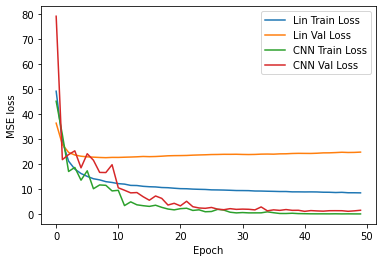

In [22]:
#  plot loss
lin_data_label = list(zip([tl_lin2,vl_lin2,tl_cnn, vl_cnn], 
                          ['Lin Train Loss','Lin Val Loss', 'CNN Train Loss','CNN Val Loss']))
quick_loss_plot(lin_data_label)

In [35]:
# train test split
idxs = list(range(df.shape[0]))
random.shuffle(idxs)
print(idxs)

split = int(len(idxs)*0.8)
train_idxs = idxs[:split]
test_idxs = idxs[split:]

print("Train #:", len(train_idxs))
print("Test #:", len(test_idxs))

[17, 1, 21, 11, 44, 42, 48, 12, 15, 20, 39, 19, 43, 36, 37, 7, 40, 18, 30, 25, 33, 45, 38, 32, 23, 10, 14, 16, 24, 13, 27, 41, 8, 31, 29, 46, 9, 5, 22, 3, 4, 34, 47, 0, 2, 26, 6, 28, 35]
Train #: 39
Test #: 10


In [36]:
train_df = df[df.index.isin(train_idxs)]
test_df = df[df.index.isin(test_idxs)]

x_train = torch.tensor(list(train_df['oh'].values))
y_train = torch.tensor(list(train_df['score'].values)).unsqueeze(1)
x_test  = torch.tensor(list(test_df['oh'].values))
y_test  = torch.tensor(list(test_df['score'].values)).unsqueeze(1)

print(x_test)
print(y_test)

tensor([[1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
         0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,

In [37]:
bs = 4

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs * 2)

lr = 0.01
epochs = 50
model_lin2 = DNA_Linear()
loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model_lin2.parameters(), lr=lr)

In [39]:
tl_lin2, vl_lin2 = fit(50, model_lin2, loss_func, optimizer, train_dl, test_dl)

0 68.09041748046874
1 49.32786865234375
2 39.55677337646485
3 34.41413192749023
4 31.67222671508789
5 30.251473236083985
6 29.120285034179688
7 28.075050354003906
8 26.81099090576172
9 25.930934143066406
10 25.401055908203126
11 24.998995971679687
12 25.110486602783205
13 25.0474494934082
14 24.43956604003906
15 24.374861907958984
16 24.2609619140625
17 23.6954833984375
18 23.551791381835937
19 23.70868377685547
20 23.182360076904295
21 22.983940887451173
22 23.02279052734375
23 22.964396667480468
24 22.60875244140625
25 22.514385223388672
26 22.417697143554687
27 22.417207336425783
28 22.191029357910157
29 22.35784454345703
30 22.562381744384766
31 21.928821563720703
32 21.614825439453124
33 21.706591033935545
34 21.803601837158205
35 21.727206420898437
36 21.717665100097655
37 21.62573699951172
38 21.69854736328125
39 21.549234771728514
40 21.34781494140625
41 21.128070068359374
42 21.394181060791016
43 21.207501220703126
44 21.21027603149414
45 21.303125
46 21.293035888671874
47 21.

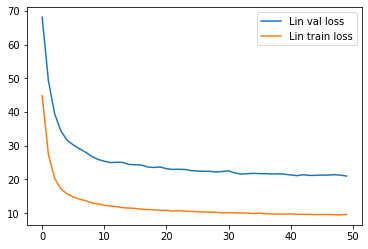

In [40]:
plt.plot(vl_lin2, label="Lin val loss")
plt.plot(tl_lin2, label="Lin train loss")
plt.legend()
plt.show()

In [42]:
for dna in ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT','AACCAA','CCGGGG','GGGTAA', 'TTTCGT',"TGTAAT"]:
    s = torch.tensor(one_hot_encode(dna))
    pred = model_lin2(s.float())
    print(dna, pred)

AAAAAA tensor([11.7176], grad_fn=<AddBackward0>)
CCCCCC tensor([5.2495], grad_fn=<AddBackward0>)
GGGGGG tensor([0.4521], grad_fn=<AddBackward0>)
TTTTTT tensor([5.0028], grad_fn=<AddBackward0>)
AACCAA tensor([5.2514], grad_fn=<AddBackward0>)
CCGGGG tensor([0.3986], grad_fn=<AddBackward0>)
GGGTAA tensor([4.0127], grad_fn=<AddBackward0>)
TTTCGT tensor([3.2138], grad_fn=<AddBackward0>)
TGTAAT tensor([10.3386], grad_fn=<AddBackward0>)


In [44]:
for dna in :
    s = torch.tensor(one_hot_encode(dna))
    pred = model_lin2(s.float())
    print(dna, pred)
    
#     ('TATAAA', 14.9),
#     ('TAATAT', 14.8),
#     ('CCTATA', 14.5),
#     ('AAGCGA', 0.6),
#     ('GCGAAA', 0.7),
#     ('TTGCGA', 0.2),


TATAAA tensor([10.8625], grad_fn=<AddBackward0>)
TAATAT tensor([8.9638], grad_fn=<AddBackward0>)
CCTATA tensor([9.1524], grad_fn=<AddBackward0>)
AAGCGA tensor([3.5378], grad_fn=<AddBackward0>)
GCGAAA tensor([6.5253], grad_fn=<AddBackward0>)
TTGCGA tensor([-0.2992], grad_fn=<AddBackward0>)
GCGTAA tensor([3.7381], grad_fn=<AddBackward0>)
TATTAA tensor([8.0753], grad_fn=<AddBackward0>)
TTTATT tensor([7.7900], grad_fn=<AddBackward0>)


In [45]:
# class DNA_CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv_net = nn.Sequential(
#             nn.Conv1d(4, 10, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.Conv1d(10,10, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.Sigmoid()) # ?? Linear?

#     def forward(self, xb):
#         xb = xb.view(-1,6,4) # reshape to 4x6
#         xb = self.conv_net(xb)
#         return xb
    
# class DNA_CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv_net = nn.Sequential(
#             nn.Conv1d(4, 16, kernel_size=(3,1)),
#             nn.ReLU(inplace=True),
#             nn.Linear(96, 1)) # ?? Linear?

#     def forward(self, xb):
#         xb = xb.view(-1,6,4) # reshape to 4x6
#         xb = self.conv_net(xb)
#         return xb

class DNA_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(128, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) # ?? Linear?

    def forward(self, xb):
        xb = xb.view(-1,6,4).permute(0,2,1) # reshape to 4bs x 4channel x 6len
        #print(xb)
        xb = self.conv_net(xb)
        return xb
    
# class DNA_Linear(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.lin = nn.Linear(24, 1)

#     def forward(self, xb):
#         # lin wraps up the weights/bias dot product from before
#         return self.lin(xb)

In [46]:
model_cnn = DNA_CNN()
loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=lr)
tl_cnn, vl_cnn = fit(50, model_cnn, loss_func, optimizer, train_dl, test_dl)

0 40.6715690612793
1 40.37783660888672
2 36.810550689697266
3 25.871519470214842
4 40.83929290771484
5 39.22800521850586
6 77.48642578125
7 27.12381362915039
8 18.393498992919923
9 17.6382194519043
10 20.524129486083986
11 21.57399215698242
12 12.914355850219726
13 11.953047943115234
14 15.0128662109375
15 12.581398391723633
16 11.565887451171875
17 6.693359756469727
18 7.235995483398438
19 7.864342117309571
20 5.465847778320312
21 7.203878021240234
22 4.886105346679687
23 4.112865829467774
24 4.8013715744018555
25 4.102758407592773
26 3.7902560234069824
27 3.8833343505859377
28 4.053083038330078
29 4.585363388061523
30 3.3617820739746094
31 3.3483532905578612
32 3.388096809387207
33 3.782131385803223
34 3.442391204833984
35 4.611374568939209
36 3.4518901824951174
37 2.7605968475341798
38 2.6472429990768434
39 2.632403039932251
40 2.490719938278198
41 2.4544651031494142
42 3.0625499725341796
43 2.4440274238586426
44 2.463066816329956
45 2.217893123626709
46 2.2091307163238527
47 2.5803

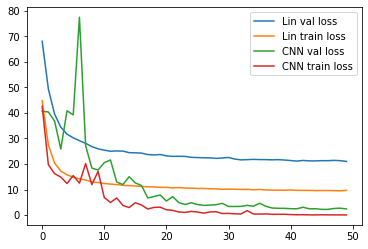

In [47]:
plt.plot(vl_lin2, label="Lin val loss")
plt.plot(tl_lin2, label="Lin train loss")
plt.plot(vl_cnn, label="CNN val loss")
plt.plot(tl_cnn, label="CNN train loss")
plt.legend()
plt.show()

In [48]:
for dna in ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT','AACCAA','CCGGGG','GGGTAA', 'TTTCGT',"TGTAAT"]:
    s = torch.tensor(one_hot_encode(dna))
    pred = model_cnn(s.float())
    print(dna, pred)

AAAAAA tensor([[9.2661]], grad_fn=<AddmmBackward>)
CCCCCC tensor([[7.0220]], grad_fn=<AddmmBackward>)
GGGGGG tensor([[3.8047]], grad_fn=<AddmmBackward>)
TTTTTT tensor([[1.0482]], grad_fn=<AddmmBackward>)
AACCAA tensor([[4.8595]], grad_fn=<AddmmBackward>)
CCGGGG tensor([[3.0401]], grad_fn=<AddmmBackward>)
GGGTAA tensor([[8.0723]], grad_fn=<AddmmBackward>)
TTTCGT tensor([[1.2749]], grad_fn=<AddmmBackward>)
TGTAAT tensor([[12.7573]], grad_fn=<AddmmBackward>)


In [50]:
for dna in ['TATAAA', 'TAATAT','CCTATA','AAGCGA','GCGAAA','TTGCGA','GCGTAA', 'TATTAA','TTTATT']:
    s = torch.tensor(one_hot_encode(dna))
    pred = model_cnn(s.float())
    print(dna, pred)
    
#     ('TATAAA', 14.9),
#     ('TAATAT', 14.8),
#     ('CCTATA', 14.5),
#     ('AAGCGA', 0.6),
#     ('GCGAAA', 0.7),
#     ('TTGCGA', 0.2),


TATAAA tensor([[15.1144]], grad_fn=<AddmmBackward>)
TAATAT tensor([[14.6269]], grad_fn=<AddmmBackward>)
CCTATA tensor([[11.5350]], grad_fn=<AddmmBackward>)
AAGCGA tensor([[0.4359]], grad_fn=<AddmmBackward>)
GCGAAA tensor([[1.0538]], grad_fn=<AddmmBackward>)
TTGCGA tensor([[0.3293]], grad_fn=<AddmmBackward>)
GCGTAA tensor([[3.9840]], grad_fn=<AddmmBackward>)
TATTAA tensor([[14.5705]], grad_fn=<AddmmBackward>)
TTTATT tensor([[13.7654]], grad_fn=<AddmmBackward>)


In [61]:
print(xb.view(-1,1,6,4))
print(xb.view(-1,6,4))

tensor([[[[1., 0., 0., 0.],
          [0., 0., 0., 1.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.]]],


        [[[0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [1., 0., 0., 0.]]],


        [[[0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.]]],


        [[[0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 1., 0.],
          [1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 1., 0., 0.]]]], dtype=torch.float64)
tensor([[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0.

In [79]:
xb.view(-1,4)

tensor([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]], dtype=torch.float64)

In [82]:
xb.shape

torch.Size([4, 24])

In [84]:
xb[0].shape

torch.Size([24])

In [89]:
xb.view(4,6,4)

tensor([[[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]],

        [[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.]]], dtype=torch.float64)

In [91]:
xb.view(-1,6,4) == xb.view(4,6,4)

tensor([[[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]],

        [[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]],

        [[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]],

        [[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]]])

In [117]:
xb.view(4,4,6).shape

torch.Size([4, 4, 6])

In [124]:
xb.view(-1,6,4).permute(0,2,1)

tensor([[[1., 0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 0., 1., 1., 0., 1.],
         [1., 1., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0.],
         [1., 0., 0., 0., 1., 1.],
         [0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]], dtype=torch.float64)

In [125]:
xb.view(-1,6,4).permute(0,2,1).shape

torch.Size([4, 4, 6])

In [ ]:
xb = x_train[0:bs]  # a mini-batch from x
preds = model_lin(xb.float()) 